In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
grodf = pd.read_csv('data/grocery_store_data_cleaned.csv')

In [3]:
grodf['DATE'] = pd.to_datetime(grodf['DATE'])
grodf.set_index('DATE', inplace=True)

In [5]:
grodf.drop(columns='Unnamed: 0',inplace = True)
grodf.columns

Index(['TICKET', 'UNITS', 'REFERENCE', 'CODE', 'NAME', 'UNIT_PRICEBUY',
       'UNIT_PRICESELL', 'PAYMENT', 'TRANSID', 'CATEGORY', 'TOTAL_PRICEBUY',
       'TOTAL_PRICESELL', 'UNIT_PRICE_MARGIN', 'PROFIT'],
      dtype='object')

In [6]:
grodf[grodf.PAYMENT=='free'].sum()

TICKET               9c178cbd-5b82-4981-be92-5e8b26fb14419c178cbd-5...
UNITS                                                           37.866
REFERENCE                                                        82684
CODE                                                       4.20816e+13
NAME                 egg free range 600gCapsicum redGarlic 500gCarr...
UNIT_PRICEBUY                                                     87.4
UNIT_PRICESELL                                                  230.72
PAYMENT              freefreefreefreefreefreefreefreefreefreefreefr...
TRANSID              no IDno IDno IDno IDno IDno IDno IDno IDno IDn...
CATEGORY             EggscapsicumOnionscarrotsMushroomsCitrusPearsO...
TOTAL_PRICEBUY                                                 39.2848
TOTAL_PRICESELL                                                129.662
UNIT_PRICE_MARGIN                                               143.32
PROFIT                                                          90.377
dtype:

In [11]:
grodf.drop(grodf.index[grodf.PAYMENT=='free'],inplace = True)

In [12]:
grodf.PAYMENT.unique()

array(['cash', 'cashrefund', 'magcard'], dtype=object)

In [22]:
grodf.drop(grodf.index[grodf.CATEGORY == 'markdown bag'],inplace = True)

I drop markdown bags

In [23]:
cats = grodf.groupby('CATEGORY')

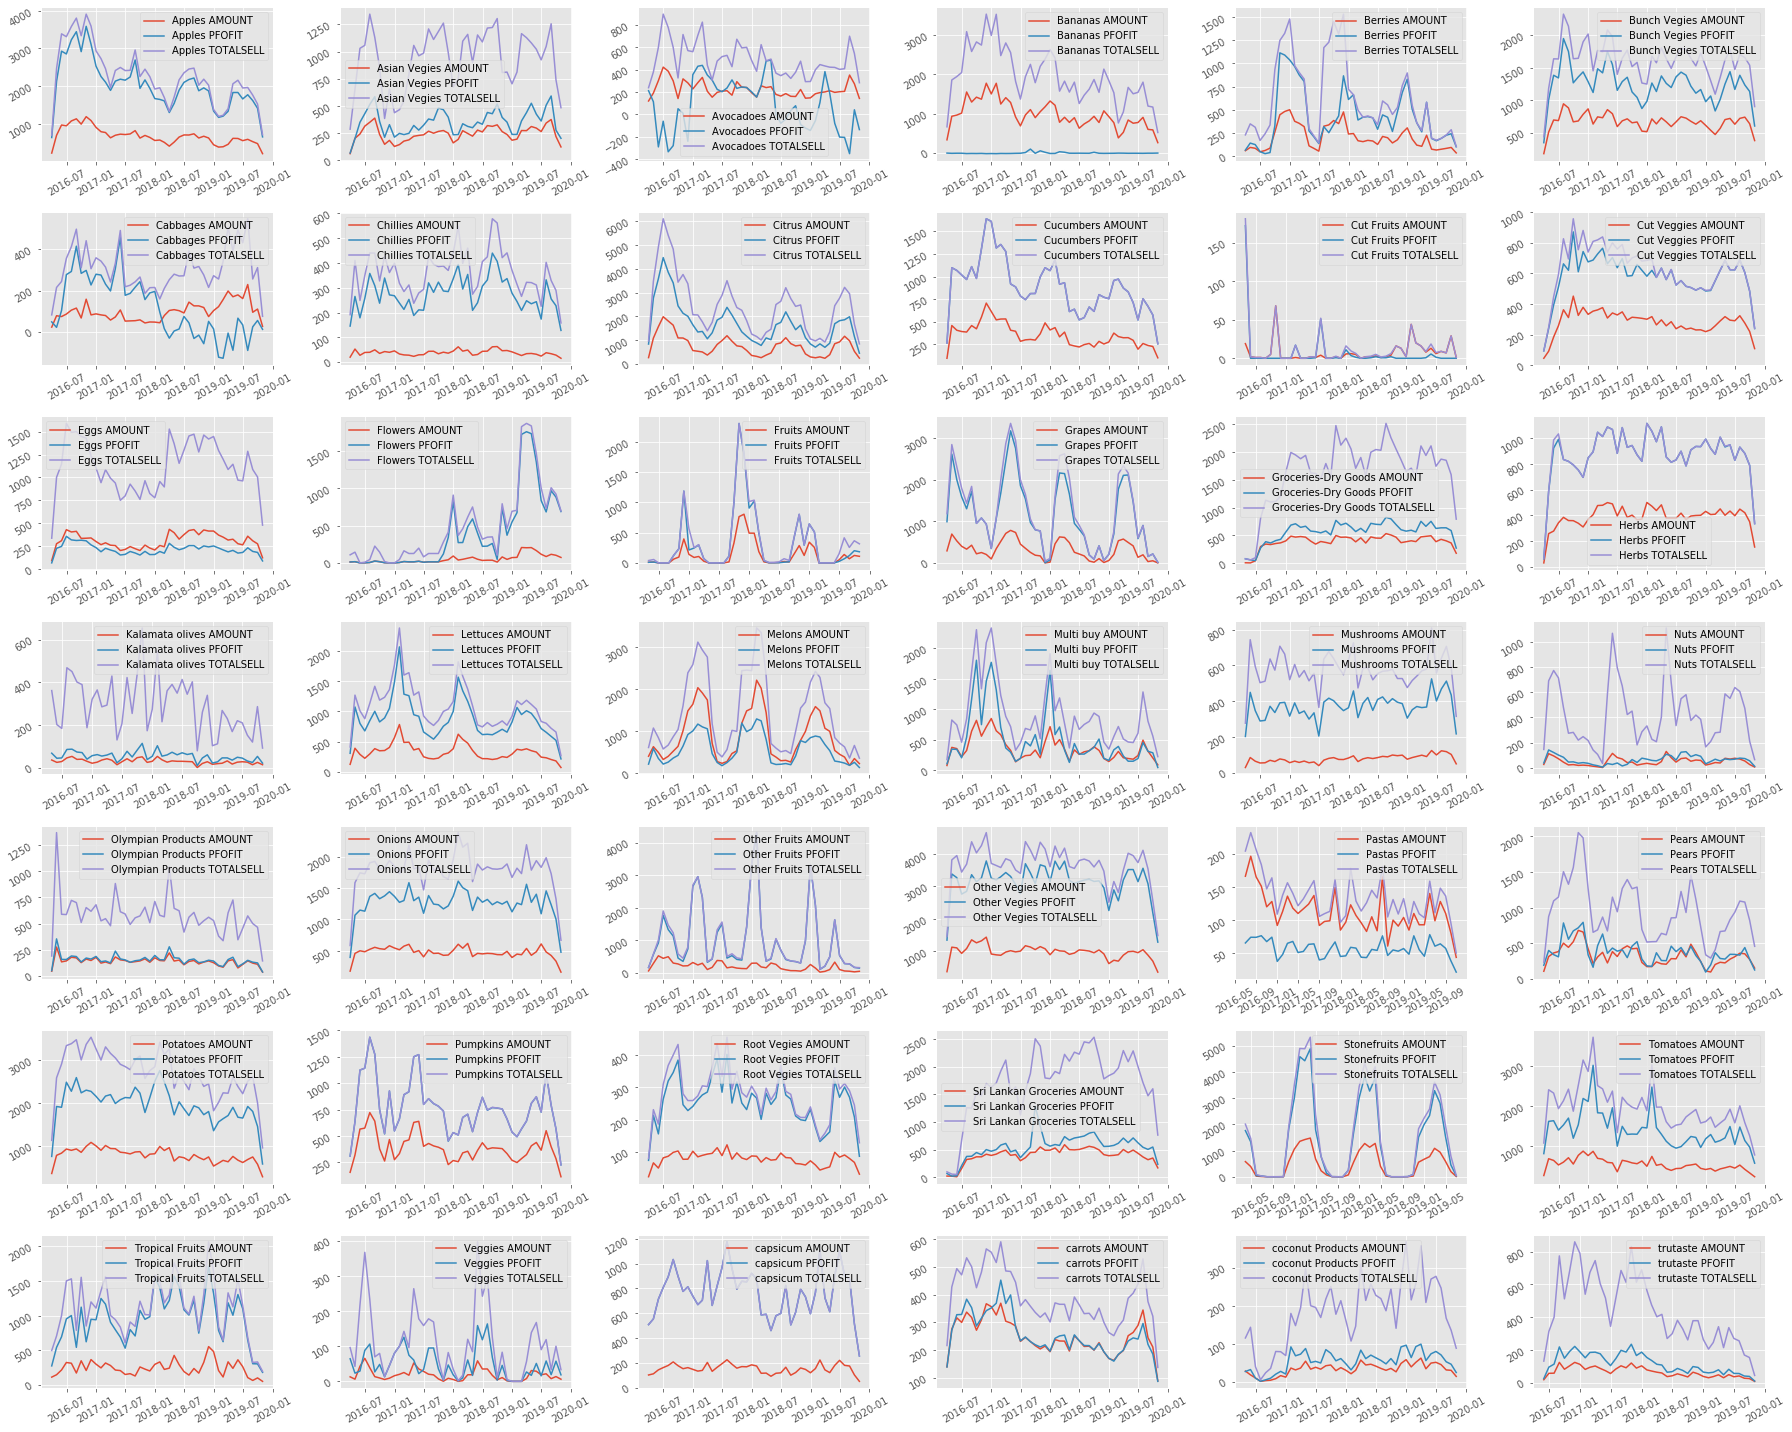

In [24]:
fig, axes = plt.subplots(7,6,figsize = (25,20))
#plt.setp(axes.xaxis.get_majorticklabels(), rotation=45)
for cat,ax in zip(cats, axes.flatten()):
    ax.plot(cat[1].resample('M').sum()['UNITS'], label = cat[0]+' AMOUNT')
    ax.plot(cat[1].resample('M').sum()['PROFIT'], label = cat[0]+' PFOFIT')
    ax.plot(cat[1].resample('M').sum()['TOTAL_PRICESELL'], label = cat[0]+' TOTALSELL')
    ax.legend()
    ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

lets try to create some model
starts with one category
say pears

In [25]:
pears = grodf[grodf.CATEGORY == 'Pears']
pears.shape

(15554, 14)

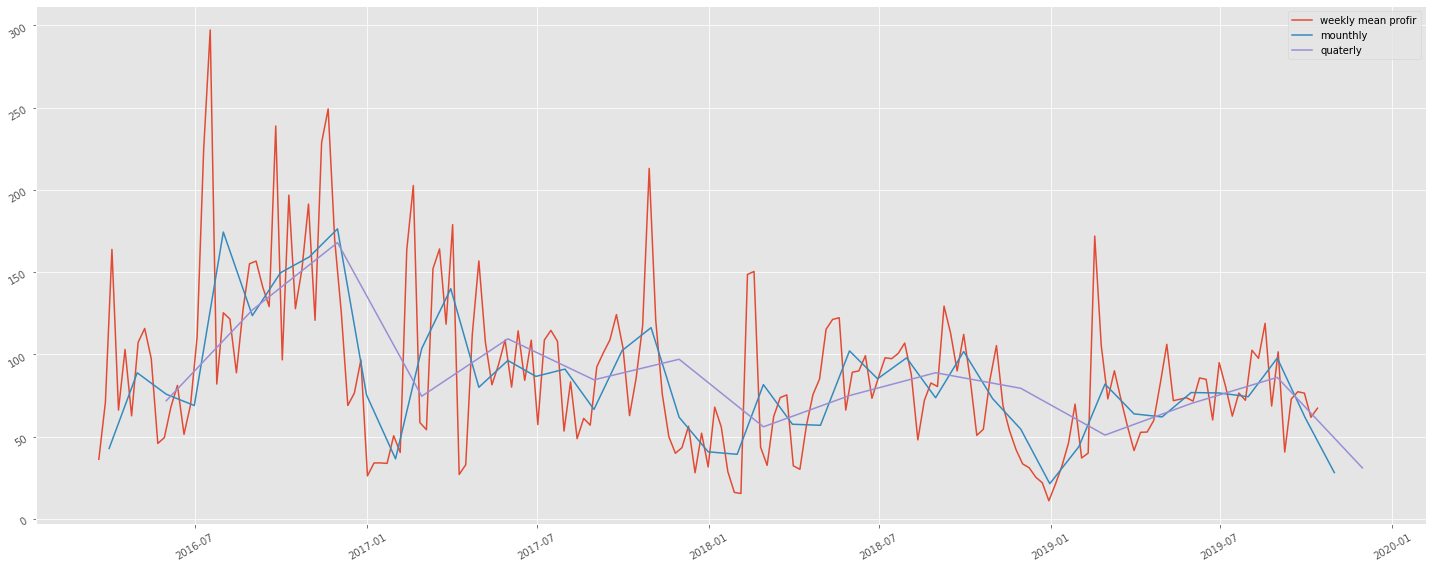

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(pears.resample('W').sum()['PROFIT'], label = 'weekly mean profir')
ax.plot(pears.resample('M').sum()['PROFIT']/4.5, label = 'mounthly')
ax.plot(pears.resample('Q-NOV').sum()['PROFIT']/13, label = 'quaterly')

ax.legend()
ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

Naive prediction for next 3 month profit --- 1000 - 1500

In [38]:
pears_prof_week = pears.resample('W').sum()['PROFIT']

In [40]:
len(pears_prof_week)

187

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [86]:
decomposition = seasonal_decompose(pears_prof_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

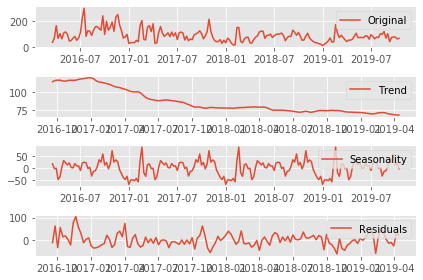

In [87]:
plt.subplot(411)
plt.plot(pears_prof_week, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [121]:
pear_diff = pears_prof_week.diff()[1:]
test = sm.tsa.stattools.adfuller(pear_diff)
print("ADF p-value for differenced pear series: {0:2.2f}".format(test[1]))

ADF p-value for differenced pear series: 0.00


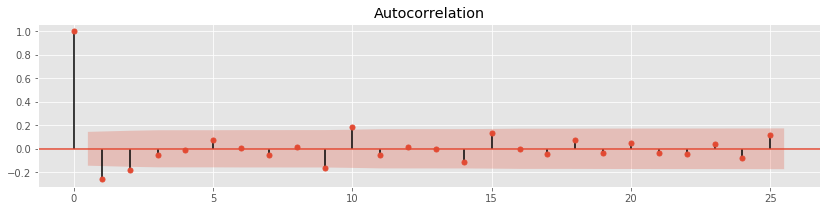

In [91]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(pear_diff, lags=25, ax=ax)

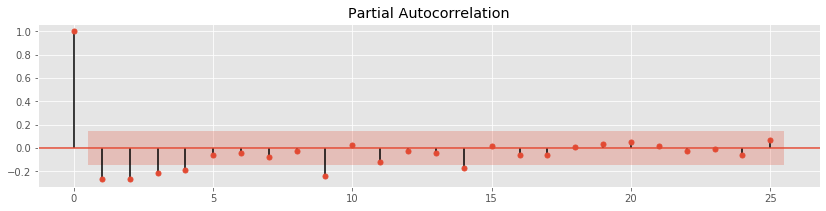

In [96]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(pear_diff, lags=25, ax=ax)

In [156]:
pear_model = ARIMA(pears_prof_week[:-10], order=(4, 1, 0)).fit()

In [126]:
print(pear_model.params)

const             0.063053
ar.L1.D.PROFIT   -0.417149
ar.L2.D.PROFIT   -0.415423
ar.L3.D.PROFIT   -0.271544
ar.L4.D.PROFIT   -0.192876
dtype: float64


In [140]:
start = pears_prof_week.index[-10]
end = pears_prof_week.index[-1]
start,end

(Timestamp('2019-08-11 00:00:00', freq='W-SUN'),
 Timestamp('2019-10-13 00:00:00', freq='W-SUN'))

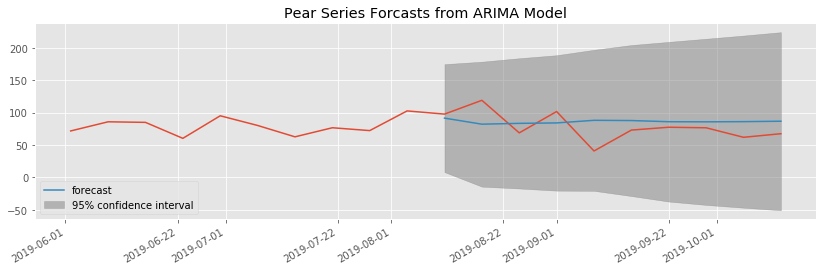

In [150]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(pears_prof_week.index[-20:], pears_prof_week[-20:])
fig = pear_model.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear Series Forcasts from ARIMA Model")

In [174]:
pear_model.predict(start, '2019-10-31')

2019-06-30     7.372558
2019-07-07    -6.623264
2019-07-14    -1.225665
2019-07-21     8.979662
2019-07-28    -1.074064
2019-08-04     3.805636
2019-08-11   -11.137922
2019-08-18    -9.357050
2019-08-25     1.264051
2019-09-01     0.661839
2019-09-08     4.032726
2019-09-15    -0.350853
2019-09-22    -1.807620
2019-09-29    -0.178086
2019-10-06     0.287502
2019-10-13     0.657402
2019-10-20     0.148167
2019-10-27    -0.233797
2019-11-03    -0.053158
Freq: W-SUN, dtype: float64

In [142]:
pear_pred = pear_model.predict(start,end)

In [173]:
pear_pred

2019-08-11   -11.137922
2019-08-18    -9.357050
2019-08-25     1.264051
2019-09-01     0.661839
2019-09-08     4.032726
2019-09-15    -0.350853
2019-09-22    -1.807620
2019-09-29    -0.178086
2019-10-06     0.287502
2019-10-13     0.657402
Freq: W-SUN, dtype: float64

In [170]:
pears_prof_week[-10:].sum()

782.7812400000001

In [169]:
(pear_pred.cumsum() +pears_prof_week[-11]).sum()

860.0367693946121

In [144]:
last = pears_prof_week[-11]

In [166]:
parameters = [
    {'AR': 5, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 5, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(pears_prof_week, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(5, 1, 0) AIC: 1930.8717278803456
ARIMA(3, 1, 1) AIC: 1916.705344514336
ARIMA(4, 1, 0) AIC: 1929.486037454024
ARIMA(4, 1, 1) AIC: 1917.899154604852
ARIMA(5, 1, 1) AIC: 1918.8169031065017


In [ ]:
3,1,1 better

In [172]:
pears_prof_week.index[-1]

Timestamp('2019-10-13 00:00:00', freq='W-SUN')

### By month

In [151]:
pears_prof_month = pears.resample('M').sum()['PROFIT']

In [152]:
decomposition = seasonal_decompose(pears_prof_month)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

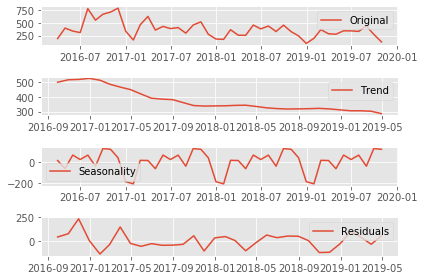

In [153]:
plt.subplot(411)
plt.plot(pears_prof_month, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [154]:
len(pears_prof_month)

44

In [158]:
pear_model_m = ARIMA(pears_prof_month[:-5], order=(3, 1, 0)).fit()
start = pears_prof_month.index[-5]
end = pears_prof_month.index[-1]
start,end

(Timestamp('2019-06-30 00:00:00', freq='M'),
 Timestamp('2019-10-31 00:00:00', freq='M'))

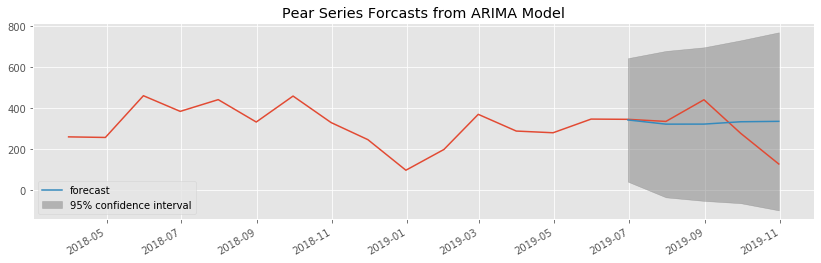

In [160]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(pears_prof_month.index[-20:], pears_prof_month[-20:])
fig = pear_model_m.plot_predict(start, end, 
                                  dynamic=False, ax=ax, plot_insample=False)

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Pear Series Forcasts from ARIMA Model")

In [164]:
mp = pear_model_m.predict(start, end).cumsum()+pears_prof_month[-6]
mp

2019-06-30    341.386476
2019-07-31    320.846106
2019-08-31    321.062475
2019-09-30    332.478871
2019-10-31    334.516567
Freq: M, dtype: float64

In [165]:
mp.sum(), pears_prof_month[-5:].sum()

(1650.2904939861046, 1520.6634)

In [167]:
parameters = [
    {'AR': 5, 'MA': 0},
    {'AR': 3, 'MA': 1},
    {'AR': 4, 'MA': 0},
    {'AR': 4, 'MA': 1},
    {'AR': 5, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(pears_prof_month, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(5, 1, 0) AIC: 564.7128196555684
ARIMA(3, 1, 1) AIC: 564.2197372978571
ARIMA(4, 1, 0) AIC: 564.1176866919648
ARIMA(4, 1, 1) AIC: 565.8427823057604
ARIMA(5, 1, 1) AIC: 568.342906784093


In [ ]:
4,1,0 -- better